In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import scipy

%matplotlib inline
from matplotlib import pyplot as plt


In [2]:
train_df = pd.read_csv('howpop_train.csv')
test_df  = pd.read_csv('howpop_test.csv')

In [3]:
train_df.head(1).T

,0
url,https://habrahabr.ru/post/18284/
domain,habrahabr.ru
post_id,18284
published,2008-01-01 18:19:00
author,@Tapac
flow,develop
polling,False
content_len,4305
title,Новогодний подарок блоггерам — WordPress 2.3.2
comments,0


In [4]:
train_df.shape, test_df.shape

((134137, 17), (3990, 9))

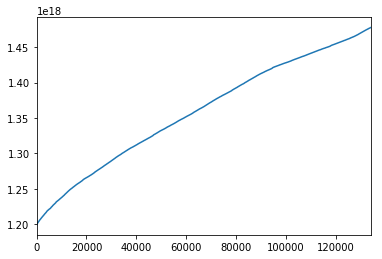

In [5]:
train_df['published'].apply(lambda ts: pd.to_datetime(ts).value).plot();

## Вопрос 1. Есть ли в train_df признаки, корреляция между которыми больше 0.9? Обратите внимание, именно различные признаки - корреляция признака с самим собой естественно больше 0.9 :)

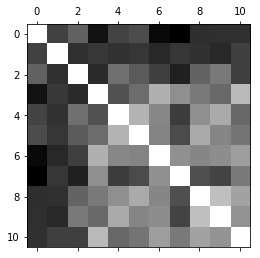

In [6]:
plt.matshow(train_df.corr(),cmap='gray')
plt.show()

In [7]:
corr_df=train_df.corr()
corr_df=corr_df.applymap(lambda x: True if x>0.9 else False )
for i in range(corr_df.shape[0]):
    corr_df.iloc[i,i]=False
t=any(corr_df.values.flatten())
if t==True:
    print("There are features with correlation over 0.9")
else:
    print("There are no such features")

There are no such features


## Вопрос 2. В каком году было больше всего публикаций? (Рассматриваем train_df)

In [12]:
train_df['published'] = pd.to_datetime(train_df.published, yearfirst = True)
train_df['year'] = [d.year for d in train_df.published]
train_df["year"].unique()

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016], dtype=int64)

In [13]:
t=train_df.groupby("year")["published"].count().idxmax()
print("The biggest number of publications was in {}".format(t))

The biggest number of publications was in 2015


In [14]:
features = ['author', 'flow', 'domain','title']
train_size = int(0.7 * train_df.shape[0])
X, y = train_df.loc[:, features],  train_df['favs_lognorm'] #отделяем признаки от целевой переменной
X_test = test_df.loc[:, features]

In [15]:
X_train, X_valid = X.iloc[:train_size, :], X.iloc[train_size:,:]

y_train, y_valid = y.iloc[:train_size], y.iloc[train_size:]

## Вопрос 3.

Инициализируйте TfidfVectorizer с параметрами min_df=3, max_df=0.3 и ngram_range=(1, 3).
Примените метод fit_transform к X_train ['title'] и метод transform к X_valid ['title'] и X_test ['title']

 Какой размер у полученного словаря?

In [21]:
vectorizer_title = TfidfVectorizer(min_df=3, max_df=0.3, ngram_range=(1, 3))
X_train_title = vectorizer_title.fit_transform(X_train["title"])
X_valid_title = vectorizer_title.transform(X_valid["title"])
X_test_title = vectorizer_title.transform(X_test["title"])

In [22]:
print("The length of the vocabulary: ",(X_train_title.shape[1]))

The length of the vocabulary:  50624


## Вопрос 4. Какой индекс у слова 'python'?

In [23]:
vectorizer_title.vocabulary_["python"]

9065

## Вопрос 5.
Инициализируйте TfidfVectorizer, указав analyzer='char'.
Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']

Какой размер у полученного словаря?

In [24]:
vectorizer_ch = TfidfVectorizer(min_df=3, max_df=0.3,  analyzer='char', ngram_range=(1, 3))
X_train_title_ch = vectorizer_ch.fit_transform(X_train["title"])
X_valid_title_ch = vectorizer_ch.transform(X_valid["title"])
X_test_title_ch = vectorizer_ch.transform(X_test["title"])


In [25]:
print("The length of the vocabulary: ",(X_train_title_ch.shape[1]))

The length of the vocabulary:  32839


In [26]:
feats = ['author', 'flow', 'domain']
X_train[feats][:5]

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,NaN,geektimes.ru


In [27]:
# сначала заполняем пропуски прочерком
X_train[feats][:5].fillna('-')

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,-,geektimes.ru


In [28]:
# Преобразуем датафрейм в словарь, где ключами являются индексы объектов (именно для этого мы транспонировали датафрейм),
# а значениями являются словари в виде 'название_колонки':'значение'
X_train[feats][:5].fillna('-').T.to_dict()

{0: {'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'},
 1: {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'},
 2: {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'},
 3: {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'},
 4: {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}}

In [29]:
# В DictVectorizer нам нужно будет передать список словарей для каждого объекта в виде 'название_колонки':'значение',
# поэтому используем .values()
X_train[feats][:5].fillna('-').T.to_dict().values()

dict_values([{'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}])

In [30]:
# В итоге получается разреженная матрица
dict_vect = DictVectorizer()
dict_vect_matrix = dict_vect.fit_transform(X_train[feats][:5].fillna('-').T.to_dict().values())
dict_vect_matrix

<5x9 sparse matrix of type '<class 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>

In [31]:
# Но можно преобразовать ее в numpy array с помощью .toarray()
dict_vect_matrix.toarray()

array([[0., 0., 1., 0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 1., 0., 1., 0., 0.]])

In [32]:
# В получившейся матрице 5 строк (по числу объектов) и 9 столбцов
# Далее разберемся почему колонок именно 9
dict_vect_matrix.shape

(5, 9)

In [33]:
for col in feats:
    print(col,len(X_train[col][:5].fillna('-').unique()))

author 4
flow 3
domain 2


In [34]:
# например, самая первая колонка называется 'author=@DezmASter' - то есть принимает значение 1 только если автор @DezmASter
dict_vect.feature_names_

['author=@DezmASter',
 'author=@Taoorus',
 'author=@Tapac',
 'author=@dennydo',
 'domain=geektimes.ru',
 'domain=habrahabr.ru',
 'flow=-',
 'flow=design',
 'flow=develop']

Инициализируйте DictVectorizer с параметрами по умолчанию.
Примените метод fit_transform к X_train[feats] и метод transform к X_valid[feats] и X_test[feats]

In [35]:
dict_vect = DictVectorizer()
X_train_feats = dict_vect.fit_transform(X_train[feats].fillna('-').T.to_dict().values())
X_valid_feats = dict_vect.transform(X_valid[feats].fillna('-').T.to_dict().values())
X_test_feats = dict_vect.transform(X_test[feats].fillna('-').T.to_dict().values())

In [36]:
X_valid_title_ch.shape

(40242, 32839)

In [37]:
X_train_new = scipy.sparse.hstack([X_train_title, X_train_feats, X_train_title_ch])
X_valid_new = scipy.sparse.hstack([X_valid_title, X_valid_feats, X_valid_title_ch])
X_test_new =  scipy.sparse.hstack([X_test_title, X_test_feats, X_test_title_ch])

## Обучение модели
Далее будем использовать Ridge, линейную модель с l2-регуляризацией.



Обучите две модели на X_train_new, y_train, задав в первой alpha=0.1 и random_state = 1, а во второй alpha=1.0 и random_state = 1

Рассчитайте среднеквадратичную ошибку каждой модели (mean_squared_error). Сравните значения ошибки на обучающей и тестовой выборках и ответьте на вопросы.



In [38]:
clf_1= Ridge(alpha=0.1, random_state = 1, fit_intercept=True, normalize=False, copy_X=True, 
           max_iter=None, tol=0.001, solver='auto')
clf_2= Ridge(alpha=1.0, random_state = 1, fit_intercept=True, normalize=False, copy_X=True, 
           max_iter=None, tol=0.001, solver='auto')

In [39]:
m_1=clf_1.fit(X_train_new,y_train)
m_2=clf_2.fit(X_train_new,y_train)

In [40]:
train_preds1 = m_1.predict(X_train_new)
valid_preds1 = m_1.predict(X_valid_new)

print('Model 1 train error: {0:.4f}'.format( mean_squared_error(y_train, train_preds1)) )
print('Model 1 test error: {0:.4f}'.format(mean_squared_error(y_valid, valid_preds1)))

Model 1 train error: 0.1087
Model 1 test error: 0.9652


In [41]:
train_preds2 = m_2.predict(X_train_new)
valid_preds2 = m_2.predict(X_valid_new)

print('Model 2 train error: {0:.4f}'.format( mean_squared_error(y_train, train_preds2)) )
print('Model 2 test error: {0:.4f}'.format(mean_squared_error(y_valid, valid_preds2)))

Model 2 train error: 0.2365
Model 2 test error: 0.6917


обе модели показывают одинаковый результат (среднеквадратичная ошибка отличается не больше чем на тысячные), регуляризация ничего не меняет

In [ ]:
#False

при alpha=0.1 модель переобучается

In [ ]:
#True

среднеквадратичная ошибка первой модели на тесте меньше

In [ ]:
#False

при alpha=1.0 у модели обощающая способность лучше, чем у при alpha=0.1

In [42]:
#True

## Baseline
Теперь попытаемся получить бейзлайн для соревования - используйте Ridge с параметрами по умолчанию и обучите модель на всех данных - соедините X_train_new X_valid_new (используйте scipy.sparse.vstack()), а целевой переменной будет y.



In [43]:
X_valid_new.shape

(40242, 101332)

In [44]:
X_train_fin=scipy.sparse.vstack([X_train_new,X_valid_new])
y_train_fin=y_train.append(y_valid)

model = Ridge()
model.fit(X_train_fin,y_train_fin)
test_preds = model.predict(X_test_new)